# L03: From Regression to Classifcation

## Lesson Objectives

By the end of this lesson students will be able to:
- Identify the utility of converting regression task to classification tasks.
- To thoughtfully determine the target class
- To explain classification feature importances `?`


## Moving From Regression to Classification

- Previously, we've created several regression models to predict the final grade for our students.
- We saw that once we removed G1 and G2 grades, it became much more difficult to predict their final score. 

- Since we cannot trust our models' predictions, we cannot trust the insights/explanations we extract from the model. 

- Our stakeholder's goal is to identify at-risk students before their final grade in order to intervene and provide additional support to those students.  The stakeholder never said that they need to know the EXACT GRADE for each student.

In this situation, it makes perfect sense to convert this task into a classification that better addresses our stakeholder business case.

In [1]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer


## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)

## set text displays for sklearn
from sklearn import set_config
set_config(display='text')

from lp_styles import *
from lp_functions import  * 

## Using pd.set_option to display more columns
pd.set_option('display.max_columns',50)

### Preprocessing

In [2]:
## Load in the student performance - portugese dataset & display the head and info
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vS6xDKNpWkBBdhZSqepy48bXo55QnRv1Xy6tXTKYzZLMPjZozMfYhHQjAcC8uj9hQ/pub?output=xlsx"

df = pd.read_excel(url,sheet_name='student-por')
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      649 non-null    object 
 1   sex         649 non-null    object 
 2   age         649 non-null    float64
 3   address     649 non-null    object 
 4   famsize     649 non-null    object 
 5   Pstatus     649 non-null    object 
 6   Medu        649 non-null    float64
 7   Fedu        649 non-null    float64
 8   Mjob        649 non-null    object 
 9   Fjob        649 non-null    object 
 10  reason      649 non-null    object 
 11  guardian    649 non-null    object 
 12  traveltime  649 non-null    float64
 13  studytime   649 non-null    float64
 14  failures    649 non-null    float64
 15  schoolsup   649 non-null    object 
 16  famsup      649 non-null    object 
 17  paid        649 non-null    object 
 18  activities  649 non-null    object 
 19  nursery     649 non-null    o

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18.0,U,GT3,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,yes,no,no,4.0,3.0,4.0,1.0,1.0,3.0,4.0,0.0,11.0,11.0
1,GP,F,17.0,U,GT3,T,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,yes,yes,no,5.0,3.0,3.0,1.0,1.0,3.0,2.0,9.0,11.0,11.0
2,GP,F,15.0,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,0.0,yes,no,no,no,yes,yes,yes,no,4.0,3.0,2.0,2.0,3.0,3.0,6.0,12.0,13.0,12.0


## Rethinking Our Target



- We need to determine what qualifies as an "at-risk" student for our stakeholder?
    - Note: talking to your stakeholder is ALWAYS a good idea when making this choice.
    
- There are several different ways we could define an at-risk student. 
    1. Students in the 30 percentile or lower (the bottom third of students)
    2. Students who fail (receive an F)
    3. Students who receive a D or an F in their final year.

- After talking with our stakeholder, we've agreed that predicting which students will receive an F would be the most effective target. 
- First, we must convert the student scores into a letter grade.

### Calculating Letter Grades from G3

- We want to determine which students will receive an F for their G3 score. Right now, we have the grades as values out of 20. 

- The school informed us that when they determine letter grades, they:
    - First convert the raw scores out of 20 into % out of 100.
    - Bin the % grades to determine the letter:
        - 'A': if G3>=90
        - 'B': if G3 is 80-90
        - 'C': if G3 is 70-80
        - 'D': if G3 is 60-70
        - 'F': if G3 is <60
        
- Our first task is to convert the G3 scores into %'s. 

In [3]:
## convert G3 to a % out of 100
df['G3(%)'] = (df['G3']/20) *100
df['G3(%)'].head()

0    55.0
1    55.0
2    60.0
3    70.0
4    65.0
Name: G3(%), dtype: float64

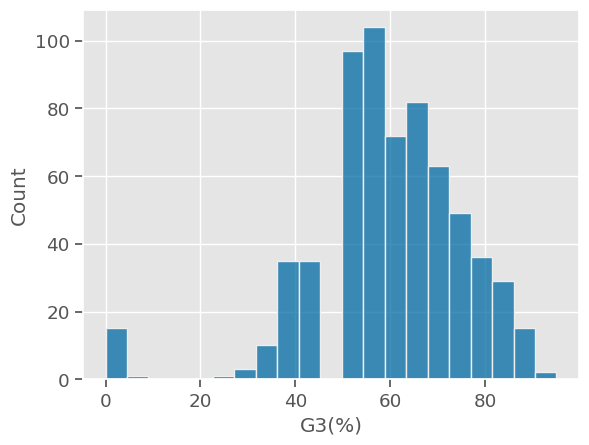

In [4]:
## visual distribution of % grades
ax = sns.histplot(data=df, x='G3(%)')

- Next we need to bin the percentages into letter grades. While there are many ways to do this, one of the most effective is to use panda's cut function. 

### Using `pd.cut`

   
- [Documentation for pd.cut](https://pandas.pydata.org/docs/reference/api/pandas.cut.html)
    - pd.cut is a very flexible function. If we simply knew how many bins we need but don't care about the actual cutoffs for each bin, we can simply provide it an integer for the number of bins.


- For our needs, we will provide a list of the exact bin edges that will be used to cut the data. 

>- Note that when we are providing a list of bin edges, we need to provide 1 more value than the # of bins we want to have.
    - For example, we want to bin the % grades into 5 bins: F,D,C,B,A
    - In order to create a list of bin edges, the very first value we include is the lowest possible value that is included in the lowest bin. Since we need to account for scores as low as 0, we need to have our first bin edge start at 0. 
    - Next, we define the right edge of the our lowest bin. Since we are binning 0 - 60 as F, the right edge will be 60. 
        - thus far we have used [0,60] to define the left and right edges of our First bin.
    - For the remainder of the bins, the right edge of the previous bin is also the left edge of the next bin. 
       - Therefore, we only need to add 70 to our bin edges to define our second bin. 
   

   

In [5]:
## defining bin edges
bins = [0,60,70,80,90,100]

grades = pd.cut(df['G3(%)'], bins=bins)
grades.value_counts().sort_index()

(0, 60]      358
(60, 70]     145
(70, 80]      85
(80, 90]      44
(90, 100]      2
Name: G3(%), dtype: int64

- Looking at the value counts above, we can see the name of the first group is: "(0,60]", the second is "(60,70]" and so on. 
    - When displaying intervals/bins, pandas uses square brackets to indicate when the number is INCLUDED in the bin or a round bracket if the number is not included in the bin. 
    
    
- So in the example above:
    - (0,60]: does include 0, but does include 60, we the logic it is capturing if  0<x<=60
        - But we want to include 0 in the bin and DON'T want to include 60. 
        
There are a couple of ways we can address this:

- We can change this by providing additional arguments to `pd.cut`:
    - right: "Indicates whether `bins` includes the rightmost edge or not." default is True.
    - If we say right=False, then the logic will change to match what we wanted, where scores up to 60 (but not 60) are defined as an F.


In [6]:

grades = pd.cut(df['G3(%)'], bins=bins,right=False)
grades.value_counts(dropna=False)

[0, 60)      301
[60, 70)     154
[70, 80)     112
[80, 90)      65
[90, 100)     17
Name: G3(%), dtype: int64

- The downside to this approach is that 100 will no longer be included in the last bin, so we would to increase the final bin edge to 101.
        

In [7]:
bins = [0,60,70,80,90,101]
grades = pd.cut(df['G3(%)'], bins=bins,right=False)
grades.value_counts()

[0, 60)      301
[60, 70)     154
[70, 80)     112
[80, 90)      65
[90, 101)     17
Name: G3(%), dtype: int64

### Adding Bin labels and saving as a column

In [8]:
## defining bins and their labels
bins = [0,60,70,80,90,101]
bin_labels = ['F','D','C','B','A']
grades = pd.cut(df['G3(%)'],bins, labels=bin_labels,include_lowest=True)
grades.value_counts()

F    373
D    145
C     85
B     44
A      2
Name: G3(%), dtype: int64

In [9]:
df['FinalGrade'] = pd.cut(df['G3(%)'],bins, labels=bin_labels,include_lowest=True)
df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,G3(%),FinalGrade
0,GP,F,18.0,U,GT3,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,yes,no,no,4.0,3.0,4.0,1.0,1.0,3.0,4.0,0.0,11.0,11.0,55.0,F
1,GP,F,17.0,U,GT3,T,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,yes,yes,no,5.0,3.0,3.0,1.0,1.0,3.0,2.0,9.0,11.0,11.0,55.0,F
2,GP,F,15.0,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,0.0,yes,no,no,no,yes,yes,yes,no,4.0,3.0,2.0,2.0,3.0,3.0,6.0,12.0,13.0,12.0,60.0,F
3,GP,F,15.0,U,GT3,T,4.0,2.0,health,services,home,mother,1.0,3.0,0.0,no,yes,no,yes,yes,yes,yes,yes,3.0,2.0,2.0,1.0,1.0,5.0,0.0,14.0,14.0,14.0,70.0,D
4,GP,F,16.0,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,no,no,yes,yes,no,no,4.0,3.0,2.0,1.0,2.0,5.0,0.0,11.0,13.0,13.0,65.0,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,MS,F,19.0,R,GT3,T,2.0,3.0,services,other,course,mother,1.0,3.0,1.0,no,no,no,yes,no,yes,yes,no,5.0,4.0,2.0,1.0,2.0,5.0,4.0,10.0,11.0,10.0,50.0,F
645,MS,F,18.0,U,LE3,T,3.0,1.0,teacher,services,course,mother,1.0,2.0,0.0,no,yes,no,no,yes,yes,yes,no,4.0,3.0,4.0,1.0,1.0,1.0,4.0,15.0,15.0,16.0,80.0,C
646,MS,F,18.0,U,GT3,T,1.0,1.0,other,other,course,mother,2.0,2.0,0.0,no,no,no,yes,yes,yes,no,no,1.0,1.0,1.0,1.0,1.0,5.0,6.0,11.0,12.0,9.0,45.0,F
647,MS,M,17.0,U,LE3,T,3.0,1.0,services,services,course,mother,2.0,1.0,0.0,no,no,no,no,no,yes,yes,no,2.0,4.0,5.0,3.0,4.0,2.0,6.0,10.0,10.0,10.0,50.0,F


In [10]:
## We can group by the letter grades and get the min/max of the scores to confirm 
df.groupby('FinalGrade')['G3(%)'].agg(['min','max','count'])

,min,max,count
FinalGrade,,,
F,0.0,60.0,373
D,65.0,70.0,145
C,75.0,80.0,85
B,85.0,90.0,44
A,95.0,95.0,2


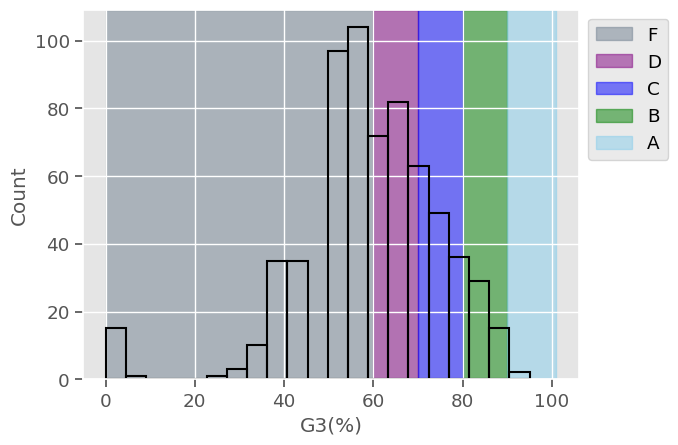

In [11]:
## visualizing the cutoffs for grades
ax = sns.histplot(data=df, x='G3(%)',color='k',fill=False)

colors = ['slategray','purple','blue','green','skyblue']
for i in range(len(bins)-1):
    x1 = bins[i]
    x2 = bins[i+1] 
    label = bin_labels[i]
    ax.axvspan(x1,x2, label=label,color=colors[i],zorder=0,alpha=.5)
ax.legend(bbox_to_anchor=[1,1])
# ax.set_xlim(right=20);

<AxesSubplot:xlabel='FinalGrade', ylabel='count'>

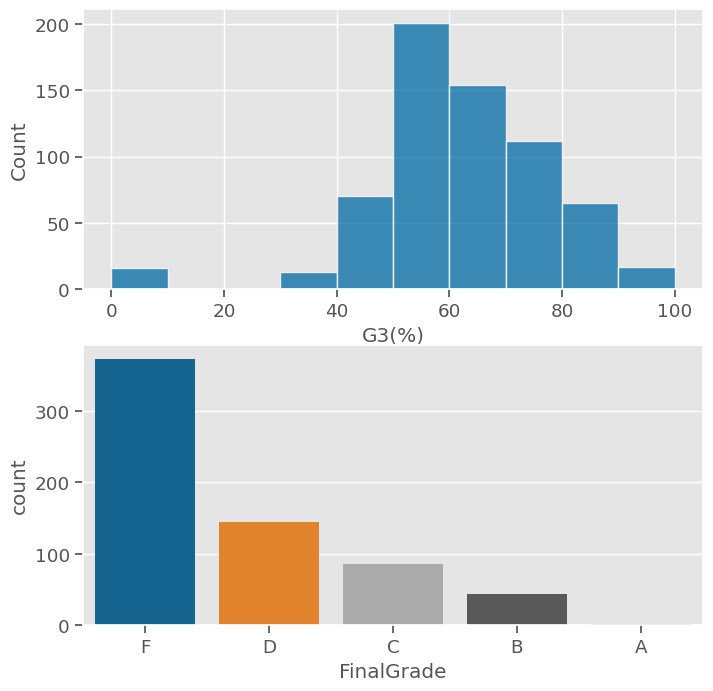

In [12]:
fig, axes = plt.subplots(nrows=2,figsize=(8,8))
sns.histplot(data=df, x='G3(%)',ax=axes[0], binwidth=10)

sns.countplot(data=df,x='FinalGrade',ax=axes[1],order=['F','D','C','B','A'])

### Making Our Final Target & X/y Data

In [13]:
## Define target as had a F or Above
df['target_F'] = df['FinalGrade'] == 'F'
df['target_F'].value_counts(normalize=True)

True     0.57473
False    0.42527
Name: target_F, dtype: float64

- We must make sure to remove the original target that we used to calculate our grades. Otherwise, G3 would be a perfect predictor of grade!

- Additionally, since we will be revisiting RandomForest first, let's use drop='if_binary' in our OneHotEncoder to keep as many categories as possible without losing information.

In [14]:
# ### Train Test Split
## Make x and y variables
drop_feats = ['G1','G2','G3','G3(%)','FinalGrade']
y = df['target_F'].copy()
X = df.drop(columns=['target_F',*drop_feats]).copy()


## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)


# ### Preprocessing + ColumnTransformer

## make categorical & numeric selectors
cat_sel = make_column_selector(dtype_include='object')
num_sel = make_column_selector(dtype_include='number')

## make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(drop='if_binary', sparse=False))

num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)


## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)

feature_names = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame(preprocessor.transform(X_train), 
                          columns = feature_names, index = X_train.index)


X_test_df = pd.DataFrame(preprocessor.transform(X_test), 
                          columns = feature_names, index = X_test.index)
X_test_df.head(3)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
104,15.0,3.0,4.0,1.0,2.0,0.0,5.0,4.0,4.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
284,18.0,2.0,1.0,1.0,1.0,2.0,3.0,2.0,5.0,2.0,5.0,5.0,4.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
579,18.0,1.0,3.0,1.0,1.0,0.0,4.0,3.0,3.0,2.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0


## RandomForestClassifier

### Function for Evaluating Classification Models

In [15]:
def evaluate_classification(model, X_train,y_train,X_test,y_test,
                            normalize='true',cmap='Blues', figsize=(10,5)):
    header="\tCLASSIFICATION REPORT"
    dashes='--'*40
    print(f"{dashes}\n{header}\n{dashes}")

    ## training data
    print(f"[i] Training Data:")
    y_pred_train = model.predict(X_train)
    report_train = metrics.classification_report(y_train, y_pred_train)
    print(report_train)

    fig,ax = plt.subplots(figsize=figsize,ncols=2)
    metrics.ConfusionMatrixDisplay.from_estimator(model,X_train,y_train,
                                                  normalize=normalize, 
                                                  cmap=cmap,ax=ax[0])
    try:
        metrics.RocCurveDisplay.from_estimator(model,X_train,y_train,ax=ax[1])
        ax[1].plot([0,1],[0,1],ls=':')
        ax[1].grid()
    except:
        pass
    fig.tight_layout()
    
    plt.show()

    
    print(dashes)
    ## training data
    print(f"[i] Test Data:")
    y_pred_test = model.predict(X_test)
    report_test = metrics.classification_report(y_test, y_pred_test)
    print(report_test)

    fig,ax = plt.subplots(figsize=figsize,ncols=2)
    metrics.ConfusionMatrixDisplay.from_estimator(model,X_test,y_test,
                                                  normalize=normalize, 
                                                  cmap=cmap, ax=ax[0])
    try:
        metrics.RocCurveDisplay.from_estimator(model,X_test,y_test,ax=ax[1])
        ax[1].plot([0,1],[0,1],ls=':')
        ax[1].grid()
    except:
        pass
    fig.tight_layout()
    plt.show()

--------------------------------------------------------------------------------
	CLASSIFICATION REPORT
--------------------------------------------------------------------------------
[i] Training Data:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       205
        True       1.00      1.00      1.00       281

    accuracy                           1.00       486
   macro avg       1.00      1.00      1.00       486
weighted avg       1.00      1.00      1.00       486



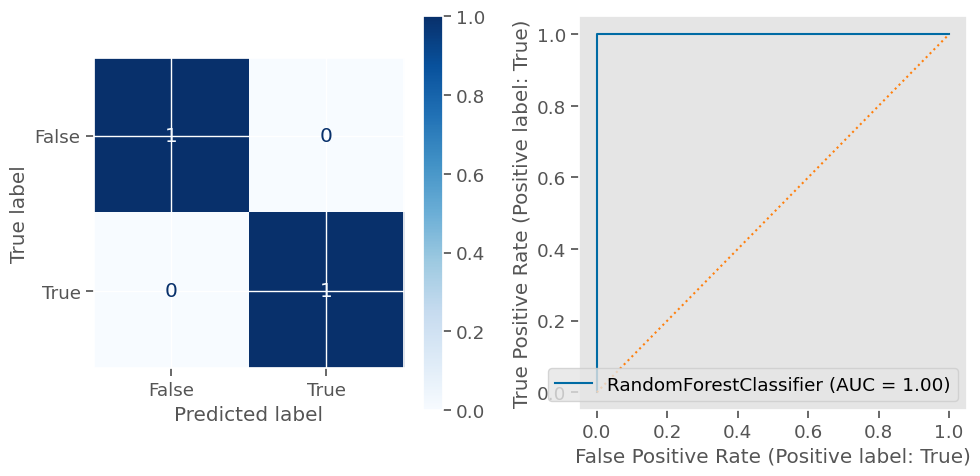

--------------------------------------------------------------------------------
[i] Test Data:
              precision    recall  f1-score   support

       False       0.81      0.70      0.75        71
        True       0.79      0.87      0.83        92

    accuracy                           0.80       163
   macro avg       0.80      0.79      0.79       163
weighted avg       0.80      0.80      0.80       163



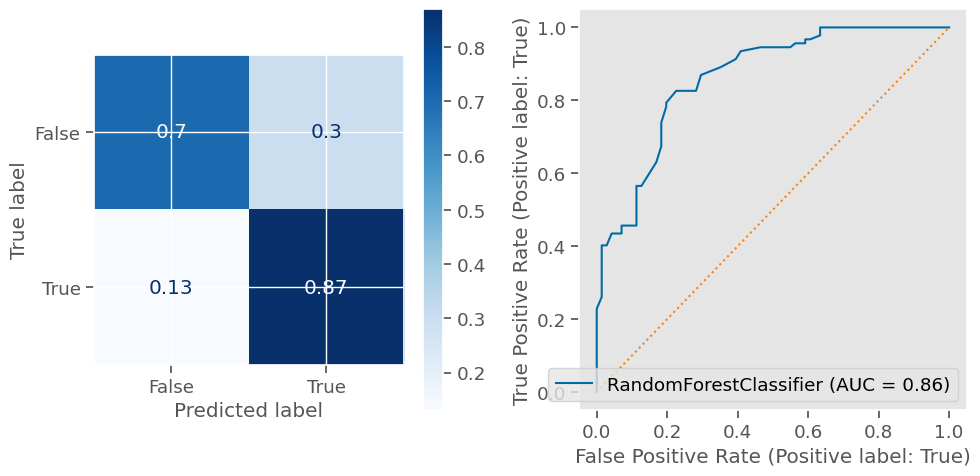

In [16]:
## fit random fores
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train_df,y_train)
evaluate_classification(rf_clf,X_train_df,y_train, X_test_df,y_test)


- We have an overall accuracy of .79, which isn't bad. However, our task is to identify the students who will get a F (the True group). So let's take a closer look at our True class scores.
    - The Recall score for True is .85. Meaning that out of all of the students who will fail, our model is identifying 85% of them correctly. While this isn't perfect (there are still 15% of students who will fall that are falling through the cracks), this is MUCH better than our R-squared of 0.35!

- As we can see above, our classification task is performing much better than our regression version of the task! This is a much more appropriate model to extract insights from.



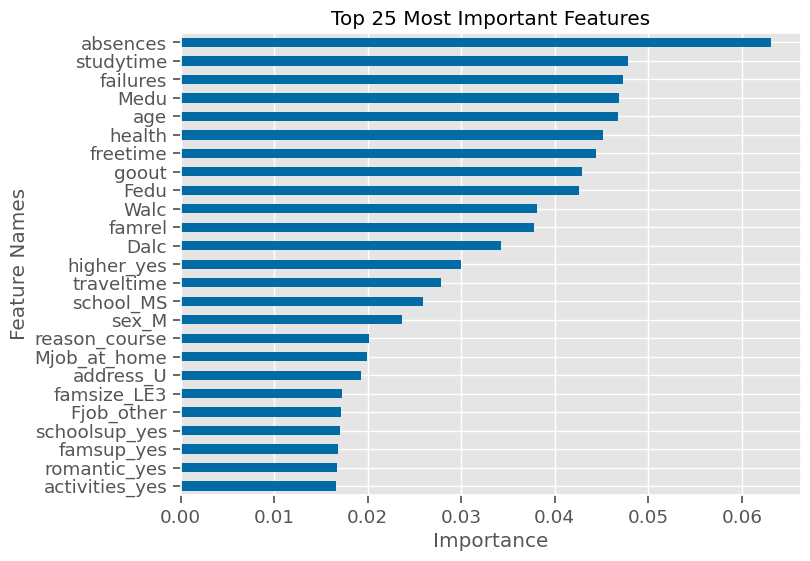

In [17]:
rf_importances = get_importances(rf_clf)
ax = plot_importance(rf_importances,top_n=25)

- As we can see above, absences, studytime, age, Medu and health are the most important features, with many other features not too far behind.

- As we discussed previously, built-in feature importances are biased towards considering numeric features as more important, so let's compare these importances to our Permutation Importance.

#### Permutation Importances - RandomForest

In [18]:
from sklearn.inspection import permutation_importance
r = permutation_importance(rf_clf,X_train_df,y_train,n_jobs=-1,n_repeats=5)
r.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [19]:
## getting the colors for the top 7 important rf features
colors_rf = get_color_dict(rf_importances,top_n=7)

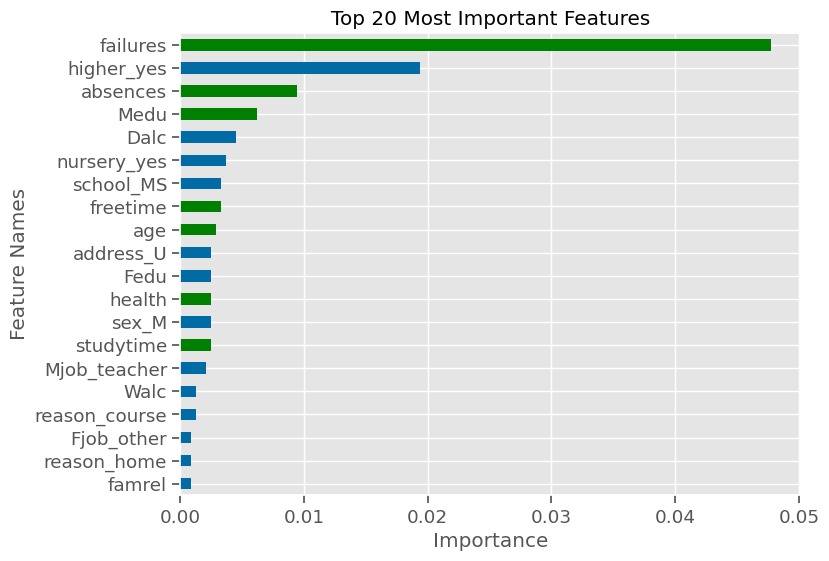

In [20]:
## can make the mean importances into a series
rf_perm_importances = pd.Series(r['importances_mean'],index=X_train_df.columns,
                           name = 'permutation importance')
rf_perm_importances = rf_perm_importances.sort_values(ascending=False)
plot_importance_color(rf_perm_importances,color_dict=colors_rf,top_n=20);

- As we can see bove, the features with the top 3 largest permutation importance were not in the random forest's top features:
    - Failures
    - higher_yes
    - school_MS
    
- As we previously discussed, built-in feature importance often overlooks categorical features. Our permutation importance, however, avoids this bias and it determined 2 out of the 3 most important features to be categorical features.

- Also as we discussed previously, neither feature importance nor permutation importance tell us the directionality of that feature vs the target.
    - higher_yes means that the student is planning to pursue higher education. We may suspect that being in this group leads to decreased likelihood of Failing, but we cannot say that for sure with just this information.

### Post-Modeling EDA

- Let's combined all of our processed data back into 1 dataframe for our final eda. 
    - This means we want to combine:
        - X_train and y_train (first)
        - X_test and y_test (second)
        - And then combine both all of the above!

In [21]:
# Combining all data for eda post-modeling
plot_df_train = pd.concat([X_train_df, y_train],axis=1)
plot_df_test = pd.concat([X_test_df, y_test],axis=1)
plot_df = pd.concat([plot_df_train, plot_df_test])
plot_df

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes,target_F
54,15.0,3.0,3.0,1.0,1.0,0.0,5.0,3.0,4.0,4.0,4.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,False
208,16.0,2.0,3.0,2.0,1.0,0.0,5.0,3.0,3.0,1.0,1.0,3.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,True
23,16.0,2.0,2.0,2.0,2.0,0.0,5.0,4.0,4.0,2.0,4.0,5.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,True
547,16.0,4.0,1.0,1.0,1.0,0.0,4.0,1.0,2.0,2.0,1.0,2.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,True
604,18.0,1.0,1.0,3.0,2.0,1.0,4.0,4.0,2.0,1.0,2.0,2.0,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,17.0,1.0,1.0,1.0,3.0,0.0,4.0,3.0,3.0,1.0,1.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,False
454,16.0,1.0,2.0,1.0,3.0,1.0,1.0,3.0,2.0,1.0,2.0,4.0,3.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,True
56,15.0,4.0,3.0,1.0,2.0,0.0,4.0,3.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,False
203,17.0,1.0,2.0,1.0,2.0,0.0,3.0,1.0,3.0,1.0,5.0,3.0,6.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,True


- Now, let's do some quick exploration of the relationship between our target and the top 3 features.

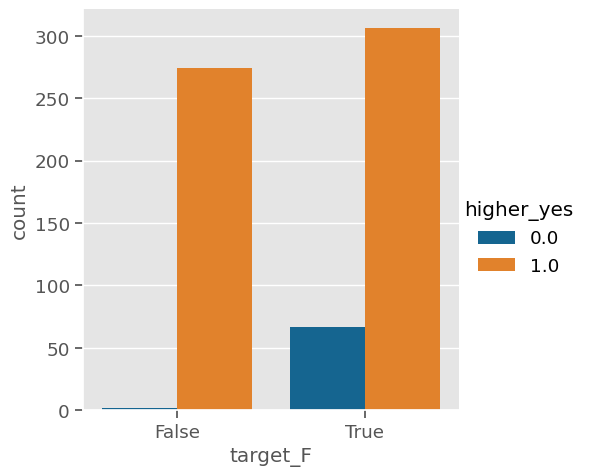

In [22]:
sns.catplot(data=plot_df, kind='count', x='target_F', hue='higher_yes');

- As we can see with out EDA above, it looks like there are a higher proportion of students that are NOT pursuing higher education (orange group) in the Failing students  (target_F==True) than the successful students. 

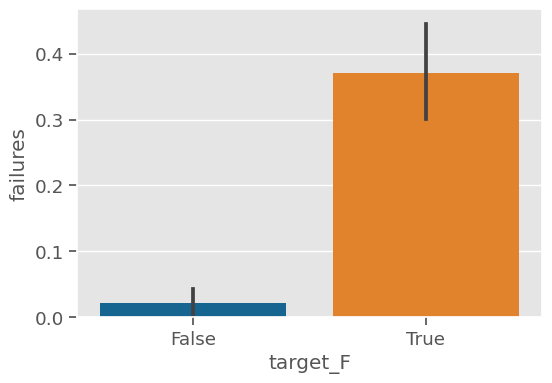

In [23]:
plt.figure(figsize=(6,4))
ax = sns.barplot(data=plot_df, x='target_F',y='failures')

- We can see that students who failed had many more failures, on average. 


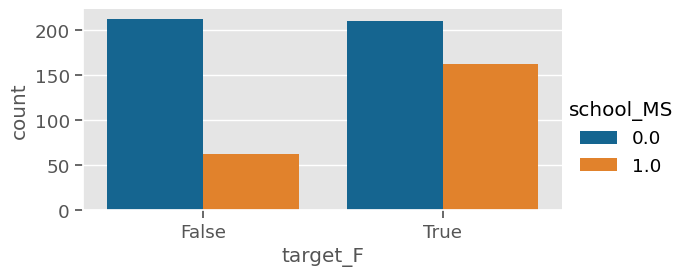

In [24]:
sns.catplot(data=plot_df, kind='count', x='target_F', hue='school_MS',
            aspect=2, height=3);

- In the next lesson, we will revisiting regression coefficients, but this time it will be for Logistic Regression coefficients for classification.

# L04: Logistic Regression Coefficients


## Lesson Objectives

By the end of this lesson, students will be able to:

- Extract and visualize coefficients from sklearn regression model.
- Compare feature importance vs regression coefficients. 
- Control pandas and matplotlib display options to facilitate interpretation. `[may be removed if new task doesn't lead to same sit]`


## Introduction

- Just like Linear Regression models calculate a coefficient for each feature to calculate the predicted value for the target, Logistic Regression model's also calculate coefficients to predict the probability of being in a specific class.

- It does this by converting a linear regression equation into a sigmoid curve, which will convert the predictions for y to a value between 0 and 1.



### Converting Our Linear Equation to A Sigmoid Curve
- Remember our that our multiple linear regression equation:

$$ \large y=\beta_1 X_1 + \beta_2 X_2 +... \beta_nX_n + b $$

where: n = the number of independent variables.

- It can be summarized as:

$$ \hat y = \sum_{i=0}^{N} \beta_i x_i $$

- By taking this equation and moving it to the denominator, we can restrict our output to values between 0 and 1.
$$\large \text{Prob} = \displaystyle \frac{1}{1+e^{-\hat y}} = \frac{1}{1+e^{-\sum_{i=0}^{N} \beta_i x_i}} $$

$$ \large = \frac{1}{1+e^{-\beta_0}e^{-\beta_1 x_1}\ldots e^{-\beta_N x_N}} $$

>- **Visual Example of Converting Linear Equation to a Sigmoid Curve** [Desmos Example](https://www.desmos.com/calculator/vk1afglgyc)

In [25]:
def calc_lin_reg(x):
    return x*2.713 - .8

$$ \large \hat{y} = 2.713 * x - 0.8 $$

$$\large \hat{y}_{\text{prob}} = \frac{1}{1+e^{ -(2.713 * x - 0.8)}} $$

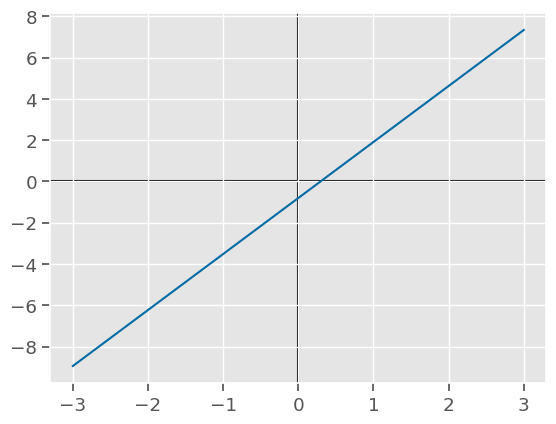

In [26]:
xs = np.linspace(-3,3)
ys = calc_lin_reg(xs)

def plot_xy(xs,ys):
    plt.plot(xs,ys)
    plt.axvline(0,color='k', zorder=0)
    plt.axhline(0, color='k', zorder=0)
    
    
plot_xy(xs,ys)

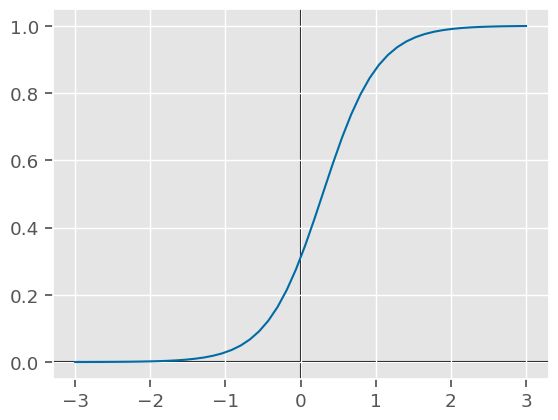

In [27]:
from math import e

def calc_sigmoid(ys):

    return 1/(1+e**-ys)

ys_sigmoid = calc_sigmoid(ys)

plot_xy(xs,ys_sigmoid)

- Now the regression equation is predicting a value between 0 and 1 - which represents the probability of being in the 1 class.

### LogisticRegression in sklearn

--------------------------------------------------------------------------------
	CLASSIFICATION REPORT
--------------------------------------------------------------------------------
[i] Training Data:
              precision    recall  f1-score   support

       False       0.73      0.71      0.72       205
        True       0.79      0.81      0.80       281

    accuracy                           0.77       486
   macro avg       0.76      0.76      0.76       486
weighted avg       0.76      0.77      0.76       486



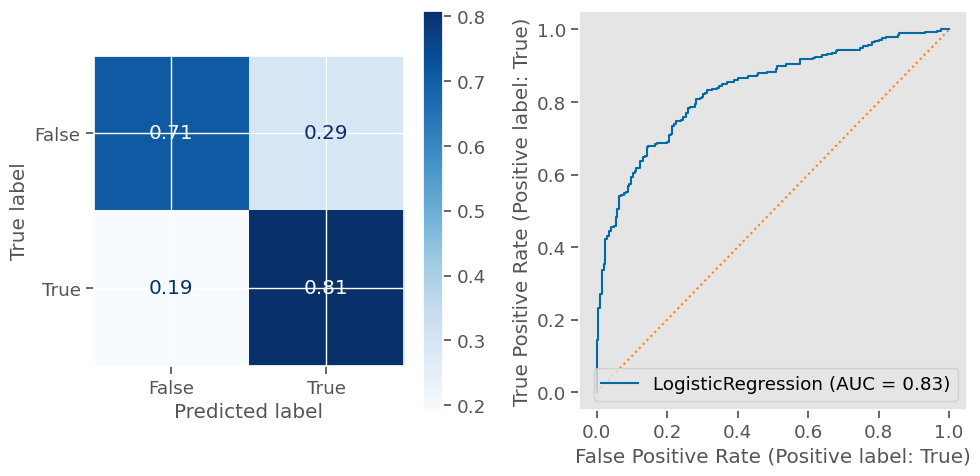

--------------------------------------------------------------------------------
[i] Test Data:
              precision    recall  f1-score   support

       False       0.73      0.69      0.71        71
        True       0.77      0.80      0.79        92

    accuracy                           0.75       163
   macro avg       0.75      0.75      0.75       163
weighted avg       0.75      0.75      0.75       163



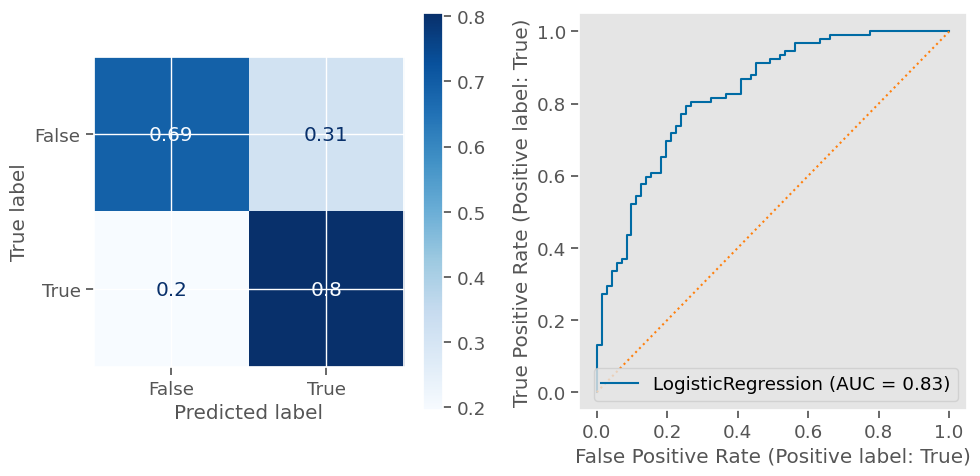

In [28]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_df, y_train)
evaluate_classification(logreg,X_train_df,y_train, X_test_df,y_test)

- As we can see above, our LogisticRegression model did not perform quite as well as our RandomForest, but it is still performing well-enough that it is worth extracting our coefficients and getting additional insights into the directionality of the effect of each feature on the target.

## Extracting Coefficients from LogisticRegression in scikit-learn

- Just like we extracted our coefficients from our lienar regression's `lin_reg.coef_`, we can also extract our logistic regression coefficients the same

- Both scikit-learn Linear Regressions & Logistic Regressions calculate coefficients.
    - However, logistic regression models will return more than 1 set of coefficients if you are predicting more than 2 classes. 

- Let's try to use our previous get_coeffs function on the logsitic regression model.

In [29]:
try:
    get_coeffs_linreg(logreg)
except Exception as e:
    print("ERROR: ", e) 

ERROR:  Length of values (1) does not match length of index (43)


- We got an error when we tried to make our coef's into a pd.Series. The reason for this is that we have an extra empty matrix around our coefficients. 

- Notice the shape of our .coef_ below has an extra first dimension added:

In [30]:
logreg.coef_

array([[-0.21993829, -0.18645801, -0.21530445, -0.33692624, -0.37112138,
         1.39690568, -0.25642045,  0.10190653,  0.12244273,  0.43111733,
        -0.11716981,  0.13290334,  0.07233101,  0.62731742,  0.6118549 ,
        -0.3243576 ,  0.1378258 ,  0.19565027,  0.41735559, -0.35001774,
        -0.19620284,  0.01730273,  0.11547738, -0.30175371,  0.37988951,
         0.32753803,  0.29200579, -0.6937645 ,  0.16844552, -0.38841528,
         0.22099695,  0.00288794, -0.14116884, -0.05299323,  0.19807719,
         0.94238383,  0.13850519,  0.12403389, -0.1860077 , -0.07972559,
        -1.70699603, -0.07349452,  0.19207778]])

- And that the intercept_ (which was a single value in LinearRegression mode) is now also wrapped in an array.

In [31]:
logreg.intercept_

array([6.26059096])

### Slicing LogReg Coefficients

- The first dimension is essential unecessary, as all of our coefficients are stored in the first (and only) index of the first dimension.


In [32]:
logreg.coef_[0]

array([-0.21993829, -0.18645801, -0.21530445, -0.33692624, -0.37112138,
        1.39690568, -0.25642045,  0.10190653,  0.12244273,  0.43111733,
       -0.11716981,  0.13290334,  0.07233101,  0.62731742,  0.6118549 ,
       -0.3243576 ,  0.1378258 ,  0.19565027,  0.41735559, -0.35001774,
       -0.19620284,  0.01730273,  0.11547738, -0.30175371,  0.37988951,
        0.32753803,  0.29200579, -0.6937645 ,  0.16844552, -0.38841528,
        0.22099695,  0.00288794, -0.14116884, -0.05299323,  0.19807719,
        0.94238383,  0.13850519,  0.12403389, -0.1860077 , -0.07972559,
       -1.70699603, -0.07349452,  0.19207778])

In [33]:
logreg.intercept_[0]

6.260590959697949

- If we were predicting more than 2 classes, we would have a dimension for each class. 
    - In this case, we would need to decide WHICH target class we wanted the extract the coefficients for and slice out the correct index.
    

#### Writing a  get_coeffs_logreg function

- Let's define a new get_coeffs_logreg function that we can use for LogisticRegression models.
    - It will be structured very similarly to our previous function, but this time we will slice out the correct index from our .ceof_ and our .intercept_
    - Since we are focusing on a binary task, let's use 0 as the default value for the class index.



In [34]:
def get_coeffs_logreg(logreg, feature_names = None, sort=True,ascending=True,
                      name='LogReg Coefficients', class_index=0):
    
    if feature_names is None:
        feature_names = logreg.feature_names_in_
        

    ## Saving the coefficients
    coeffs = pd.Series(logreg.coef_[class_index],
                       index= feature_names, name=name)
    
    # use .loc to add the intercept to the series
    coeffs.loc['intercept'] = logreg.intercept_[class_index]

    if sort == True:
        coeffs = coeffs.sort_values(ascending=ascending)
        
    return coeffs

In [35]:
coeffs = get_coeffs_logreg(logreg)
coeffs

higher_yes          -1.706996
Fjob_teacher        -0.693764
reason_home         -0.388415
studytime           -0.371121
Mjob_health         -0.350018
traveltime          -0.336926
address_U           -0.324358
Fjob_at_home        -0.301754
famrel              -0.256420
age                 -0.219938
Fedu                -0.215304
Mjob_other          -0.196203
Medu                -0.186458
activities_yes      -0.186008
guardian_father     -0.141169
Walc                -0.117170
nursery_yes         -0.079726
internet_yes        -0.073495
guardian_mother     -0.052993
reason_reputation    0.002888
Mjob_services        0.017303
absences             0.072331
freetime             0.101907
Mjob_teacher         0.115477
goout                0.122443
paid_yes             0.124034
health               0.132903
famsize_LE3          0.137826
famsup_yes           0.138505
reason_course        0.168446
romantic_yes         0.192078
Pstatus_T            0.195650
guardian_other       0.198077
reason_oth

- There we go! We have our new get_coeffs function designed explicitly for logistic regression.

>- Note: an even better solution would be to make a get_coeffs function that is flexible enough to work for either type of regression! We won't cover this in our lessons, but if you write a function that does this, share it with your cohort on Discord!

### Visualizing Our Coefficients

- We previously wrote a plot_coeffs function that should already work with our logistic regression coefficients, now that we have them in a Series. 
- Let's test and confirm that it works!

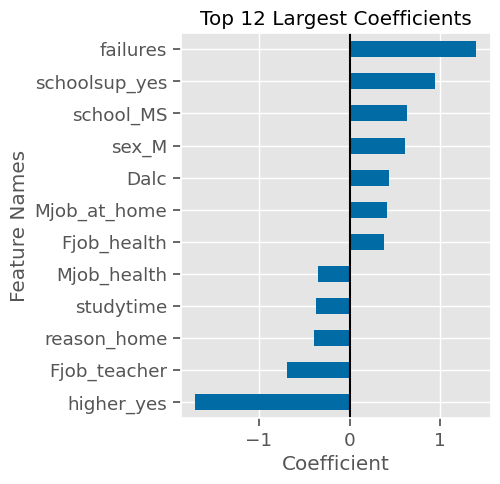

In [36]:
ax = plot_coeffs(coeffs,top_n=12)


>- Excellent! Now let's explain what our coefficients are telling us

## Interpreting LogisticRegression Coefficients

- Previously, when we interpreted the coefficients of our linear regression, we said that the coefficient for a feature represents how much our target will change for every increase of 1 in our feature. 
    - E.g. Increasing failures by 1 increased G3 by ~ 1.3 points per failure.
- For OneHotEncoded features, increasing the value of that feature by 1 really meant the effect of being in that category on the target.
    - E.g. Intending to go to college (higher_yes ==1) increased the final grade by 1.695.
    
- But now that our target is a classification, how do we interpret their meaning?
    

- At the start of the lesson, we discussed how logistic regression converts a linear regression equation into a S-shaped (sigmoid) curve. We said the result is that the curve predicts a probability value between 0 and 1 instead of the actual score.

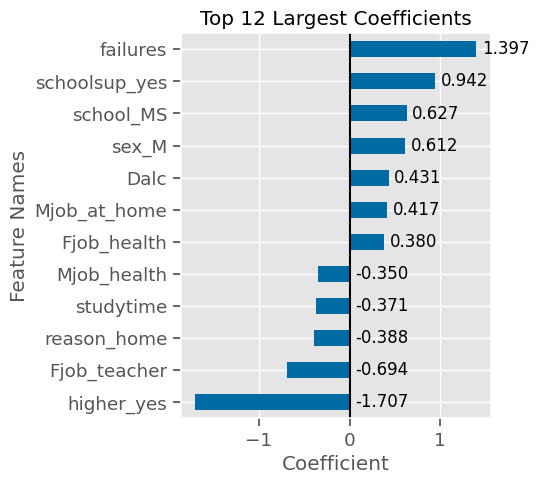

In [37]:
ax = plot_coeffs(coeffs,top_n=12,annotate=True)

- In our figure above, we have both positive and negative coefficients. 
    - Positive values indicate the feature makes it more likely the student will fail (class==True) 
    - Negative values indicate the feature makes it more less likely the student will fail.
    
    
- If you look closely, we actually have some values that are larger than +1 or less than -1. But we said that that logistic regression returns a probability less than 1?
    - So whats going on? What are these coefficient values?

### LogisticRegression Returns Log Odds Coefficents

>"...logistic regression coefficients represent the **log odds** that an observation is in the target \class (“1”) given the values of its X variables. Thus, ***these log odd coefficients need to be converted to regular odds in order to make sense of them***. Happily, this is done by simply exponentiating the log odds coefficients, which you can do with np.exp()"<br>- Source: [Medium Blog Post on Interpreting Linear Regression and Logistic Regression Coefficients](https://towardsdatascience.com/interpreting-coefficients-in-linear-and-logistic-regression-6ddf1295f6f1)


    

- In order for us to explain the logistic regression coefficients in plain english, we first need to convert the log-odds into odds.

#### Additional Resources
- If you'd like a better understanding of why log-odds are used in machine learning check out:
    - [StackExchange: Why use [log]odds instead of probability in logistic regression?](https://stats.stackexchange.com/questions/215349/why-use-odds-and-not-probability-in-logistic-regression#:~:text=The%20logarithm%20of%20an%20odds,t%20lead%20to%20impossible%20predictions.)

- For an intuitive explanation of logs/logarithms, check out the following videos:
    - [StatQuest: Logs (logarithms), Clearly Explained!!!](https://youtu.be/VSi0Z04fWj0)
    - [StatQuest: Odds and Log(Odds), Clearly Explained!!!](https://www.youtube.com/watch?v=ARfXDSkQf1Y)
    - [StatQuest:Odds Ratios and Log(Odds ratios), Clearly Explained!!!](https://www.youtube.com/watch?v=8nm0G-1uJzA)


### Converting Log-Odds to Odds 

- To convert our log-odds coefficients into odds, we need to take our coefficient euler's number (the math constant $e$) and raise to the power of our coefficient (`e**coeff`).


In [38]:
## logodds coeff for higher_yes
coeffs.loc['failures']

1.3969056781685938

In [39]:
## Raising e to the power of our logodss coeff 
import math
math.e**coeffs.loc['failures'] 

4.042671266968

- This returns the "odds" of being in the positive class (in our case - the odds of failing vs passing).

- By using np.exp(), we can do this to our entire series at once:

<AxesSubplot:title={'center':'All Coefficients - Ranked by Magnitude'}, xlabel='Coefficient', ylabel='Feature Names'>

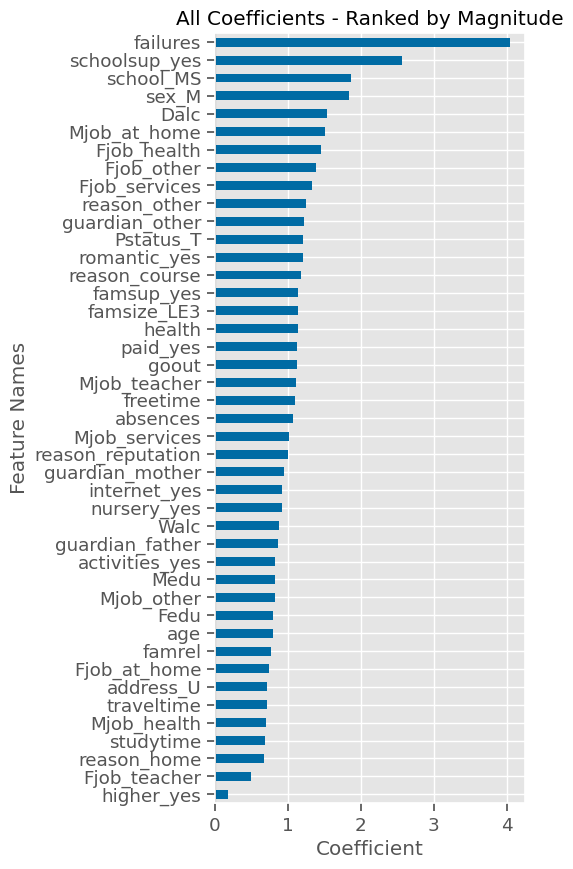

In [77]:
coeffs_odds = np.exp(coeffs)
plot_coeffs(coeffs_odds, figsize=(4,10))

- Notice that our intercept is now an extremely large value compared to the actual coefficients. We will exclude the intercept from our figures for visibility purposes. 
- Let's add this as an option in our get_coeffs_logreg  function!

### Updating our function


- Let's also add a boolean argument for if we want to convert the log-odds into odds right away.

In [41]:
def get_coeffs_logreg(logreg, feature_names = None, sort=True,ascending=True,
                      name='LogReg Coefficients', class_index=0, 
                      as_odds=False)d:
    
    if feature_names is None:
        feature_names = logreg.feature_names_in_
        
    ## Saving the coefficients
    coeffs = pd.Series(logreg.coef_[class_index],
                       index= feature_names, name=name)
    
    # use .loc to add the intercept to the series
    coeffs.loc['intercept'] = logreg.intercept_[class_index]
        
    if as_odds==True:
        coeffs = np.exp(coeffs)

    if sort == True:
        coeffs = coeffs.sort_values(ascending=ascending)
    
        
    return coeffs

In [42]:
coeffs_odds = get_coeffs_logreg(logreg, as_odds=True)
coeffs_odds

higher_yes             0.181410
Fjob_teacher           0.499691
reason_home            0.678131
studytime              0.689960
Mjob_health            0.704676
traveltime             0.713962
address_U              0.722992
Fjob_at_home           0.739520
famrel                 0.773817
age                    0.802568
Fedu                   0.806296
Mjob_other             0.821846
Medu                   0.829893
activities_yes         0.830267
guardian_father        0.868343
Walc                   0.889434
nursery_yes            0.923370
internet_yes           0.929141
guardian_mother        0.948386
reason_reputation      1.002892
Mjob_services          1.017453
absences               1.075011
freetime               1.107280
Mjob_teacher           1.122409
goout                  1.130254
paid_yes               1.132054
health                 1.142140
famsize_LE3            1.147776
famsup_yes             1.148556
reason_course          1.183464
romantic_yes           1.211765
Pstatus_

### Interpreting Odds

>- **Odds are how much more likely to fall into 1 class than 0 class.**
    - A value of 1 means both classes are equally like. 
    - A value > 1 means that the 1 class is more likely than the 0 class.
    - A value < 1 means that the 1 class is less likely than the 0 class.
    
    
- You've likely encountered odds in real world situations/conversations. 
    - "What are the odds that the horse A will win the race over horse B?"
    - In other words, how many times more likely is horse A to win vs horse B?

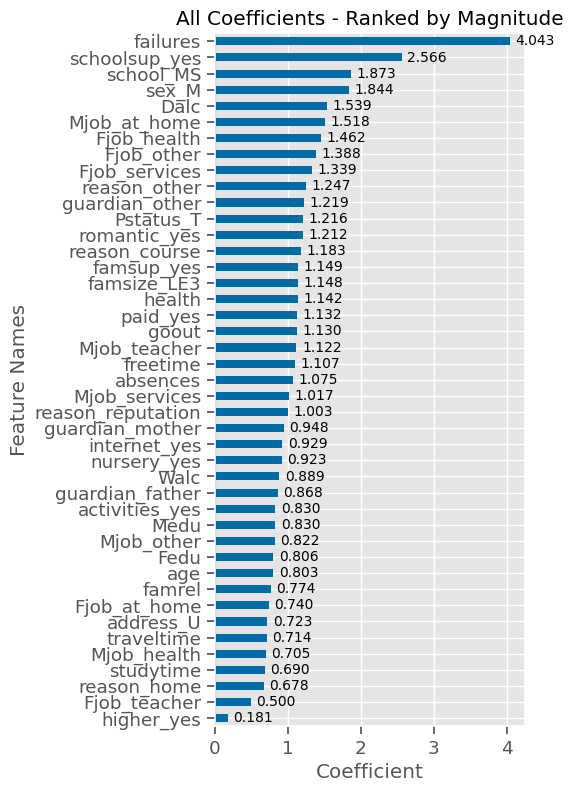

In [43]:
coeffs_odds = get_coeffs_logreg(logreg, as_odds=True)
ax = plot_coeffs(coeffs_odds,annotate=True,figsize=(4,9),size=10)

#### Interpreting Odds Coefficients
> ***“For every one-unit increase in [X variable], the odds that the observation is in (y class) are [coefficient] times as large as the odds that the observation is not in (y class) (when all other variables are held constant).”***

- Let's walk through interpreting some of our largest odds coefficients:
    - failures:
        - For every additional failure, the odds of a student failing is 4.043 times the odds of failing.
    - schoolsup_yes:
        - Getting extra support from the school increases the odds of failing by 2.566
    - school_MS:
        - students who attend MS (and not GP) are 1.873 times more likely to fail.
    - sex_M:
        - male students are 1.844 times more likely to fail than female students.

        
    


#### Note About Odds being Positive
- Now that we have odds coefficients, we no longer have any negative values. 
    - This means that any of our larg negative coefficients log-odds  coefficients that decreased the chances of the failing are now the smallest values.

    - In other words, we can no longer use the magnitude of the coefficients to determine the most impactful, since a very small ceofficient will still represent a big change.
    
- Looking back at our smallest odds coefficients, we can see that:
    - higher_yes:
        - students who intended to pursue higher education are .18 times more likely to fail (meaning they are much less likely to fail).
        - Or we could say that these students are .18 times less likely to fail.

    - Fjob_teacher:
        - having a father who is a teacher decreases the odds of failing by .5
    - reason_home:
        - attending the school because its close to their home decreases the odds of failing by .678 times
        
`NOTE TO BRENDA: thoughts on coefficient phrasing above?`


## Presenting Logistic Regression Coefficients to Non-Technical Stakeholders

    
- To help us digest and interpret the coefficients better, let's add a vertical line at 1 (where 1= equally likely of Failing or Passing).

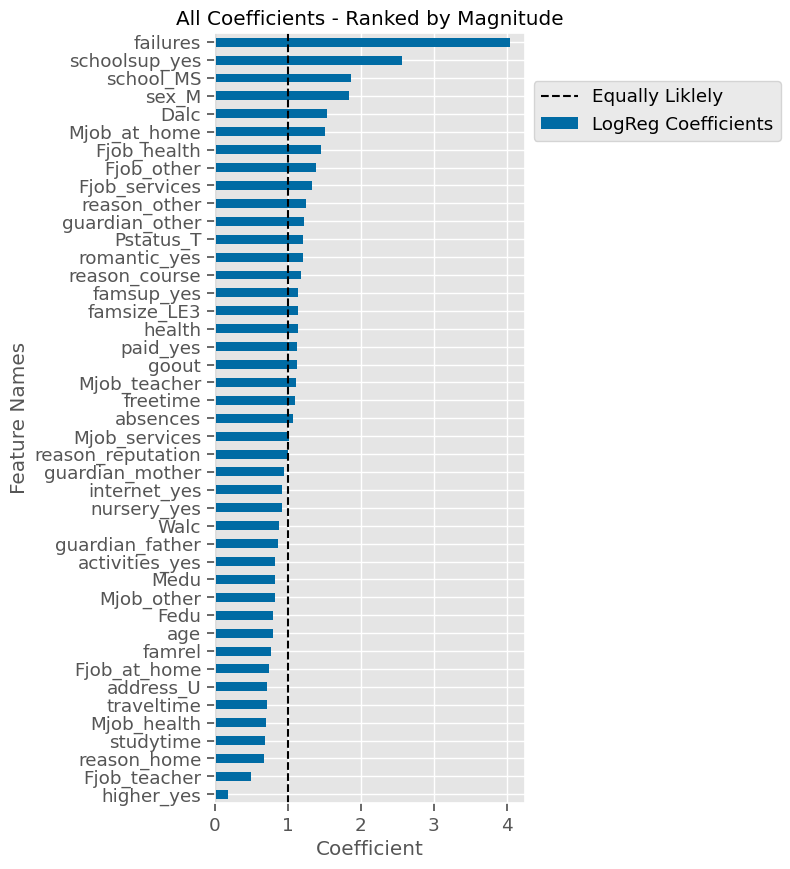

In [44]:
ax = plot_coeffs(coeffs_odds,annotate=False,figsize=(4,10))
ax.axvline(1, ls='--',label='Equally Liklely',color='k', zorder=1)
ax.legend(bbox_to_anchor=[1,.95])

- When presenting a summary of your model's findings to a non-technical stakeholder, you have the choice of which version of the coefficients you show.
- Depending on your comfort level for interpreting odds, you may want to leave the coefficients as log-odds to get a nice/clean + vs - value for each feature.

### Visualizing Odds Coefficients more effectively

- If you are comfortable explaining odds and use color-coding and/or a vertical line indicating the threshold between more/less likely, then using odds coefficients may work better for you.

- To aid in the visual interpretation of Odds, we can color-code the values greater than 1 and less than 1.


- See the next (optional) lesson for how to accomplish this yourself!

<img src="images/odds_coeffs.png">

## Summary

-  In this lesson we reviewed the extraction and interpretation of Logistic Regression coefficients. 
- The Logistic Regression coefficients provided more information about the directionality of the relationship between our features and our target.
    - However, our Logistic Regression did not perform as well as our RandomForest model.
    
- It would be great if we had a tool that would allow us to get the directionality of the features effect on our model's predictions for all models, not just Logistic Regression model.
    - There is indeed such a tool! Which we will explore in the next lesson.

# (Optional)Advanced Matplotlib:  Value-Based Color and Manual Legends 

## Learning Objectives

By the end of this lesson, students will be able to:
- Color matplotlib bars based on values
- Manually construct a matplotlib legend
- Annotate matplotlib figures

## Color-Coding By Value

In [45]:
colors_dict = {}

for i in coeffs_odds.index:
    
    rounded_coeff = np.round( coeffs_odds.loc[i],3)
    
    if rounded_coeff < 1:
        color = 'darkred'
        
    elif rounded_coeff> 1:
        color = 'forestgreen'
        
    else:
        color='gray'
        
    colors_dict[i] = color
        

## previewing example >1 and <1
colors_dict['age'],colors_dict['higher_yes']

('darkred', 'darkred')

- We will now convert this code into a function, but we will add some flexibility.
- To use this function for positive/negative or other value comparisons:
    - Let's add an argument called `threshold` that will be 1 by default, but will be the value compared to determine the color.
    - Let's also turn the 3 colors into keyword arguments in case we want to change them.

In [46]:
def get_colors_gt_lt(coeffs, threshold=1, color_lt ='darkred', 
                    color_gt='forestgreen',color_else='gray'):
    """Creates a dictionary of features:colors based on if value is > or < threshold"""
    
    colors_dict = {}

    for i in coeffs.index:

        rounded_coeff = np.round( coeffs.loc[i],3)

        if rounded_coeff < threshold:
            color = color_lt

        elif rounded_coeff > threshold:
            color = color_gt

        else:
            color=color_else

        colors_dict[i] = color
        
    return colors_dict

In [47]:
def plot_coeffs_color(coeffs, top_n=None,  figsize=(8,6), intercept=False,
                      color_dict=None, plot_kws = {}):
    """Plots series of coefficients
    
    Args:
        ceoffs (pands Series): importance values to plot
        top_n (int): The # of features to display (Default=None). 
                        If None, display all.
                        otherwise display top_n most important
                        
        figsize (tuple): figsize tuple for .plot
        color_dict (dict): dict with index values as keys with color to use as vals
                            Uses series.index.map(color_dict).
        plot_kws (dict): additional keyword args accepted by panda's .plot
                            
    Returns:
        Axis: matplotlib axis
        """
    
    if intercept==False:
        coeffs = coeffs.drop('intercept')
    
    if top_n is None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients"

    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)

        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        ## sort features and keep top_n and set title
        title = f"Top {top_n} Largest Coefficients"
        
    ## plotting top N importances
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        plot_kws.update({'color':colors})
        

    ax = plot_vals.plot(kind='barh', figsize=figsize,**plot_kws)
    ax.set(xlabel='Coefficient', 
           ylabel='Feature Names', 
           title=title)
    
    ## return ax in case want to continue to update/modify figure
    return ax

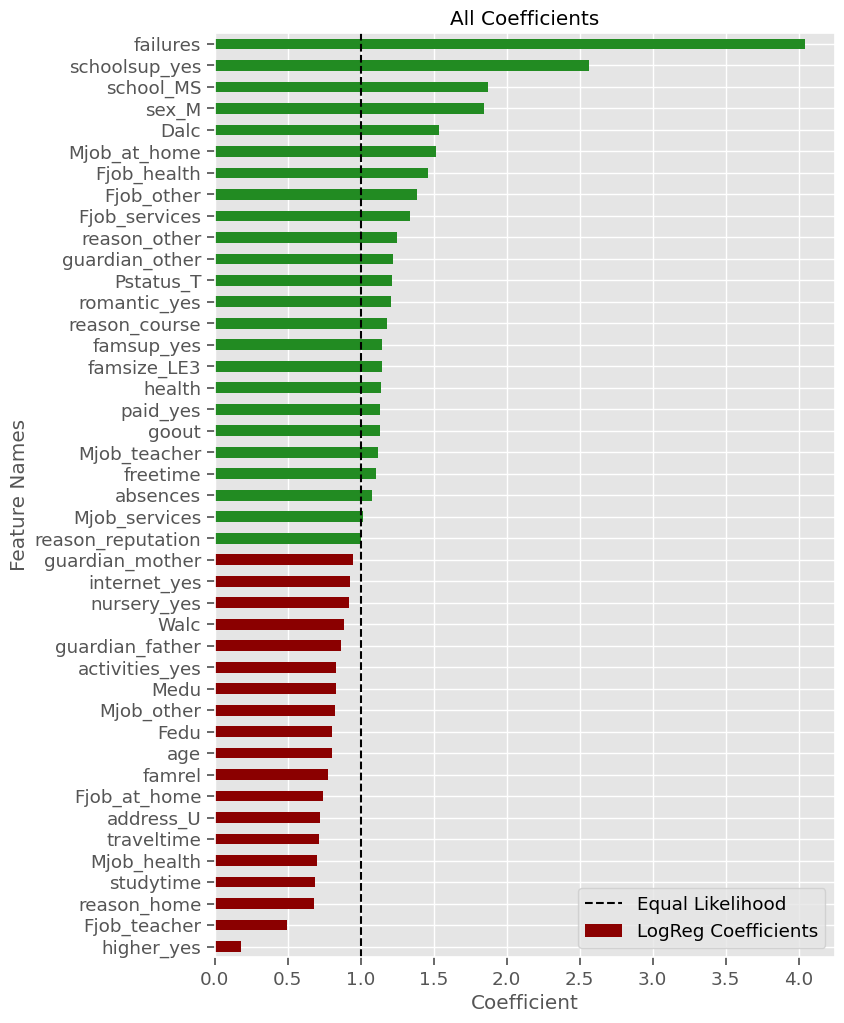

In [48]:
colors_odds = get_colors_gt_lt(coeffs_odds,threshold=1)
ax = plot_coeffs_color(coeffs_odds,color_dict=colors_odds,figsize=(8,12))
ax.axvline(1, ls='--',label='Equal Likelihood',color='k',
          zorder=1)
ax.legend();

### Manually Constructing Our Own Legend

- In the example above, we can see that in our legend, we only have the dark red color and it does not indicate the meaning of the color.

- In order to include these, we will have to make our own legend instead of the automatically determined one.
- To make this easier on ourselves, let's save the color_lt and color_gt we will use to get our color dict as separate variables. 
    - This will allow us to easily add this functionality to our function.

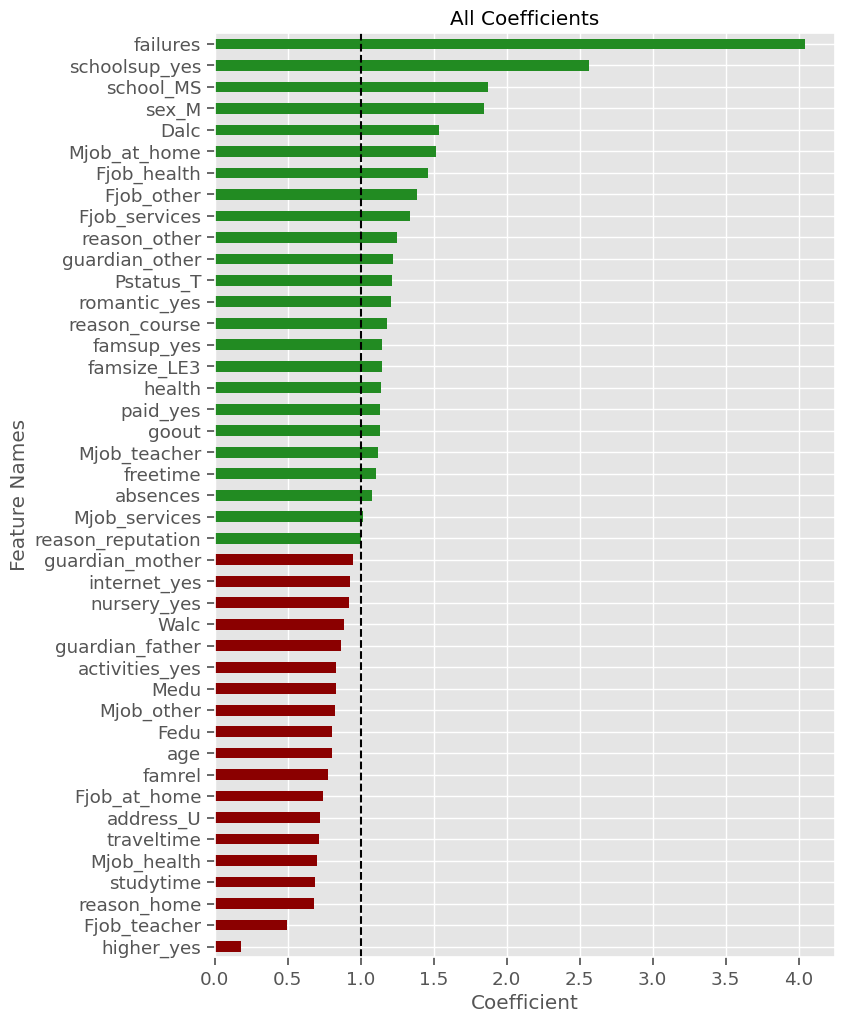

In [49]:
color_lt = 'darkred'
color_gt = 'forestgreen'

colors_odds = get_colors_gt_lt(coeffs_odds,threshold=1,color_lt=color_lt,
                              color_gt=color_gt)
ax = plot_coeffs_color(coeffs_odds,color_dict=colors_odds,figsize=(8,12))
ax.axvline(1, ls='--',label='Equal Likelihood',color='k',
          zorder=1);

- In order for us to construct our legend, we will need to manually create a box representing each color we've used. 
    - These boxes are instances of matplotlib's Patch class and it is located in matplotlib.patches.
    - Additionally, when we add the axvline, we will save the output of that line.

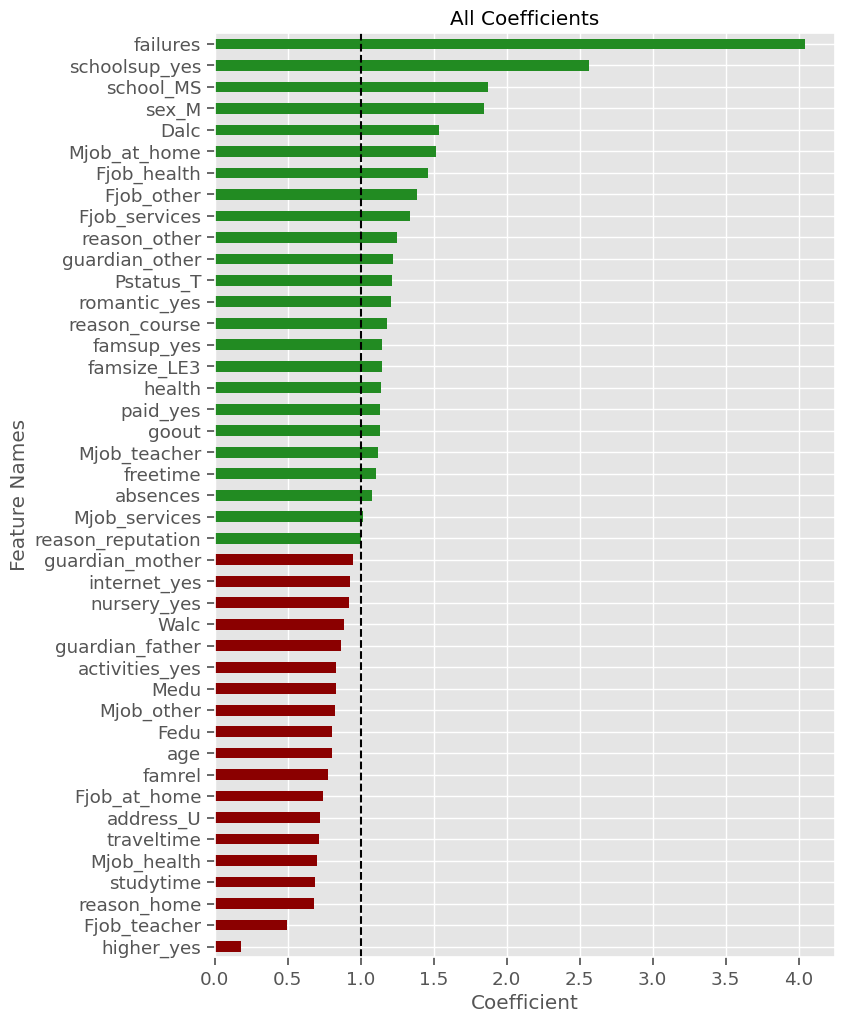

In [50]:
color_lt = 'darkred'
color_gt = 'forestgreen'

colors_odds = get_colors_gt_lt(coeffs_odds,threshold=1,color_lt=color_lt,
                              color_gt=color_gt)
ax = plot_coeffs_color(coeffs_odds,color_dict=colors_odds,figsize=(8,12))
axline = ax.axvline(1, ls='--',label='Equal Likelihood',color='k',
          zorder=1);

In [51]:
from matplotlib.patches import Patch
box_lt = Patch(color=color_lt)
box_gt = Patch(color=color_gt)

- Now that we have these objects created, we will need to use `ax.legend()`, but we will provide it a list of the objects to include (the "handles") and the name of each object (the "labels")

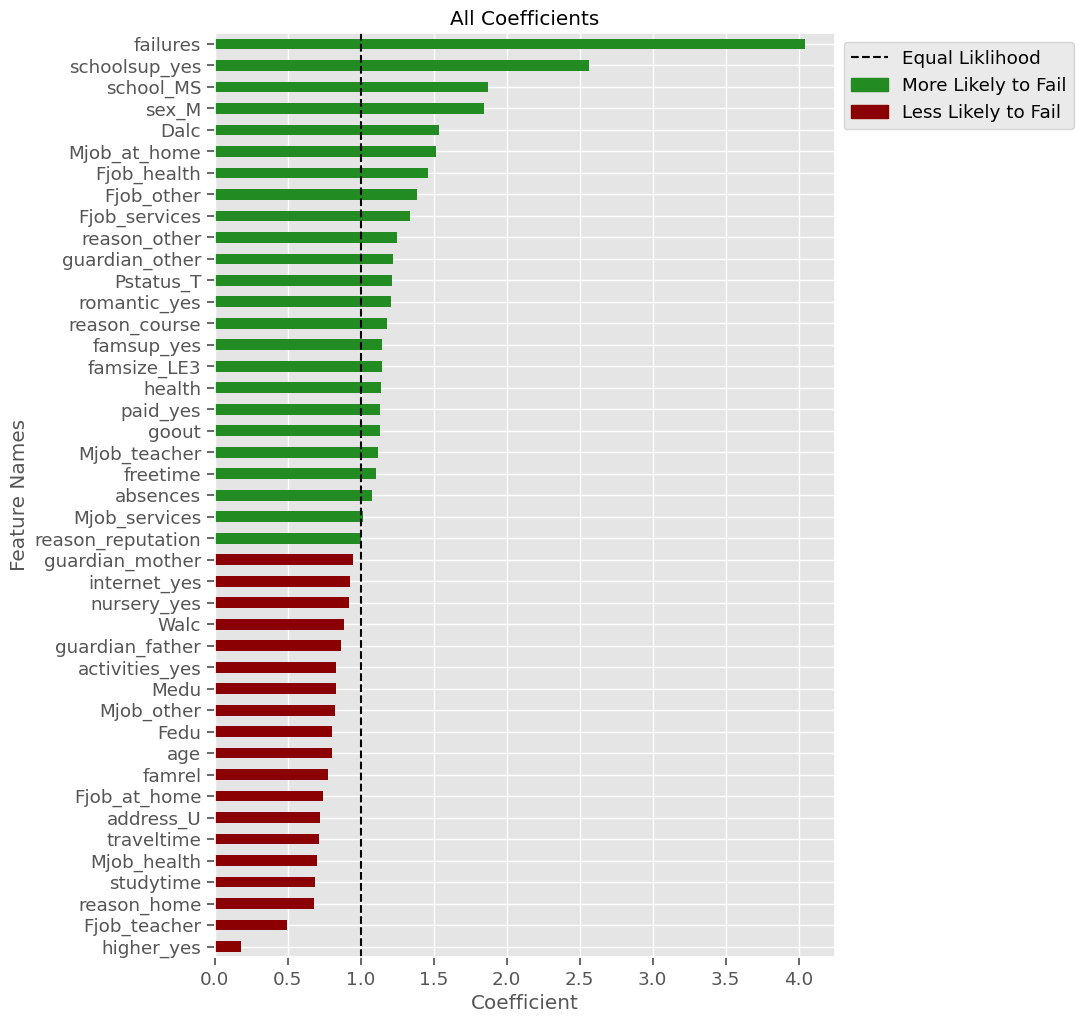

In [52]:
## make list of handles and associated labels
handles = [axline,box_gt,box_lt]
labels = ['Equal Liklihood','More Likely to Fail', "Less Likely to Fail"]

ax.legend(handles,labels,bbox_to_anchor=[1,1])

## remember - we can't see the ax on its own, so we nee the figure!
ax.get_figure()

### Adding Custom Legends to our function

- To allow for the greatest flexibility, let's make the labels we used for our legend additional arguments for our function.
- Since we are using our color dict to color code by value, instead of coordinating across figures, we can build getting the color dict into our plot_coeffs function.
    - We will just need to make sure we add every argument that our `get_colors_gt_lt` function takes to our `plot_coeffs_color`function.
    
- To control whether we want to use our function to color code our coefficients, we can either add a boolean argument for `color_bars=True/False`.
    -  We could also set the default value for our threshold to None and then only if threshold is not None, will it get and use the color dictionary.

In [64]:
def plot_coeffs_color(coeffs, top_n=None,  figsize=(8,6), intercept=False,
                      legend_loc='best', threshold=None, 
                      color_lt='darkred', color_gt='forestgreen',
                      color_else='gray', label_thresh='Equally Likely',
                      label_gt='More Likely', label_lt='Less Likely',
                      plot_kws = {}):
    """Plots series of coefficients
    
    Args:
        ceoffs (pands Series): importance values to plot
        top_n (int): The # of features to display (Default=None). 
                        If None, display all.
                        otherwise display top_n most important
                        
        figsize (tuple): figsize tuple for .plot
        color_dict (dict): dict with index values as keys with color to use as vals
                            Uses series.index.map(color_dict).
        plot_kws (dict): additional keyword args accepted by panda's .plot
                            
    Returns:
        Axis: matplotlib axis
        """
    
    # sorting with asc=false for correct order of bars
    
    if intercept==False:
        coeffs = coeffs.drop('intercept')
    
    if top_n is None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients"

    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)

        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        ## sort features and keep top_n and set title
        title = f"Top {top_n} Largest Coefficients"
        
    ## plotting top N importances
    if threshold is not None:
        color_dict = get_colors_gt_lt(plot_vals, threshold=threshold,
                                      color_gt=color_gt,color_lt=color_lt,
                                      color_else=color_else)
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        plot_kws.update({'color':colors})
        

    ax = plot_vals.plot(kind='barh', figsize=figsize,**plot_kws)
    ax.set(xlabel='Coefficient', 
           ylabel='Feature Names', 
           title=title)
    
    if threshold is not None:
        ln1 = ax.axvline(threshold,ls=':',color='black')

        from matplotlib.patches import Patch
        box_lt = Patch(color=color_lt)
        box_gt = Patch(color=color_gt)

        handles = [ln1,box_gt,box_lt]
        labels = [label_thresh,label_gt,label_lt]
        ax.legend(handles,labels, loc=legend_loc)
    ## return ax in case want to continue to update/modify figure
    return ax

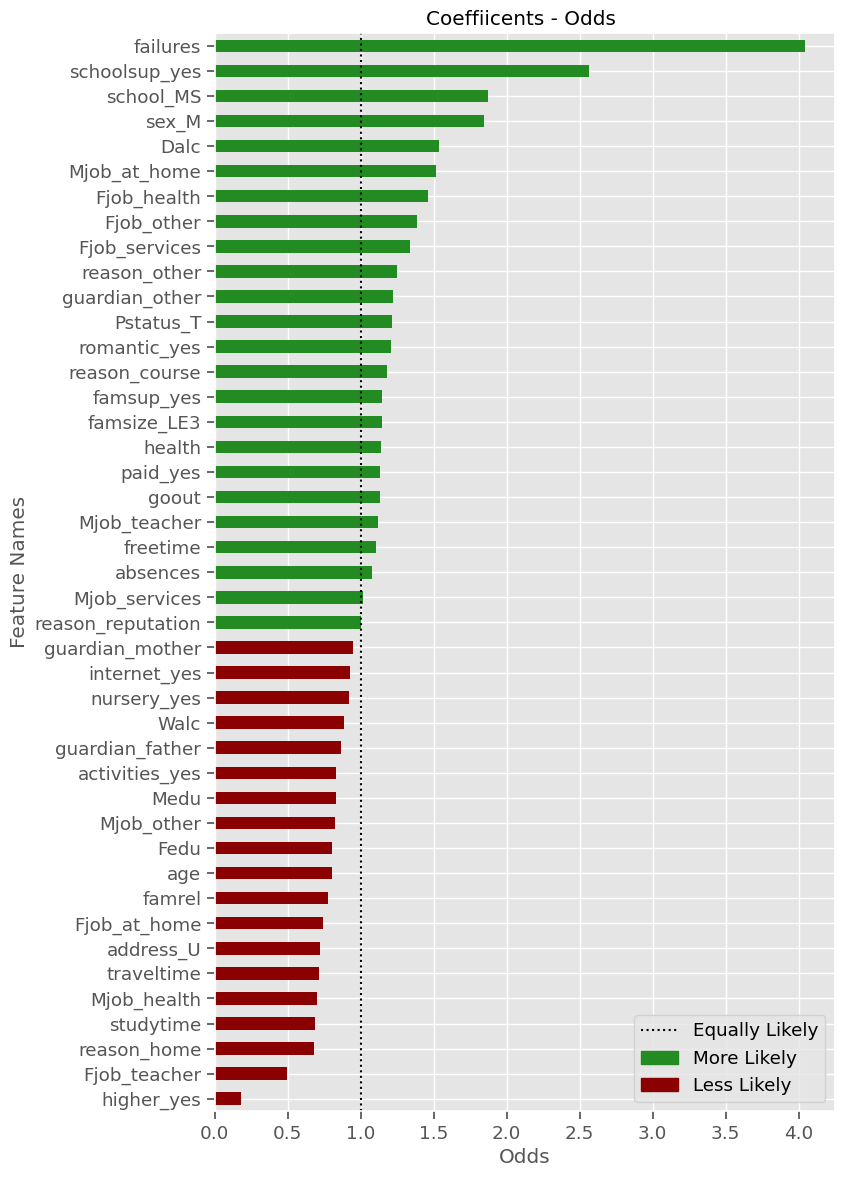

In [65]:
ax = plot_coeffs_color(coeffs_odds,threshold=1,figsize=(8,14));
ax.set(xlabel='Odds', title='Coeffiicents - Odds ')
fig = ax.get_figure()
fig.savefig('images/odds_coeffs.png', transparent=False)

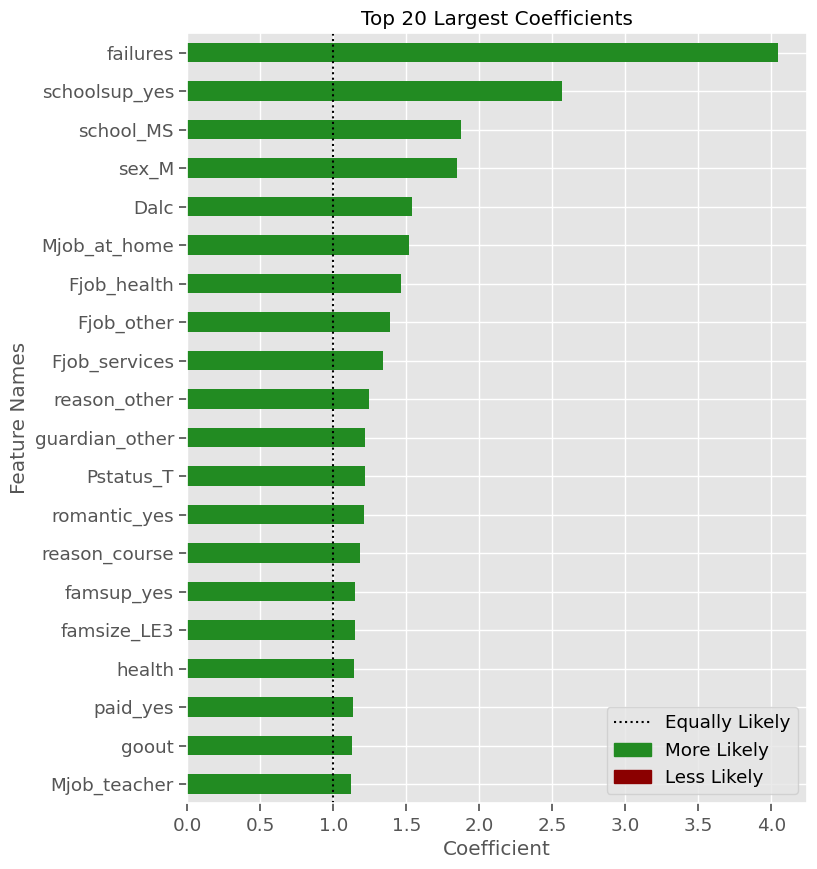

In [66]:
## Odds are how much more likely to fall into 1 class than 0 class
coeffs_odds = np.exp(get_coeffs_logreg(logreg,sort=True,ascending=False,))
ax = plot_coeffs_color(coeffs_odds,figsize=(8,10),threshold=1,top_n=20)
fig = ax.get_figure()

In [67]:
raise Exception('Appendix below!')

Exception: Appendix below!

# APPENDIX:

### Converting Odds Coefficients to Probability

> `Brenda: I could see ax'ing the probability versions`


$$odds = \frac {probability} {1 - probability}$$

$$probability = \frac {odds} {1 + odds}$$



In [68]:
coeffs_odds = np.exp(get_coeffs_logreg(logreg))
coeffs_odds

higher_yes             0.181410
Fjob_teacher           0.499691
reason_home            0.678131
studytime              0.689960
Mjob_health            0.704676
traveltime             0.713962
address_U              0.722992
Fjob_at_home           0.739520
famrel                 0.773817
age                    0.802568
Fedu                   0.806296
Mjob_other             0.821846
Medu                   0.829893
activities_yes         0.830267
guardian_father        0.868343
Walc                   0.889434
nursery_yes            0.923370
internet_yes           0.929141
guardian_mother        0.948386
reason_reputation      1.002892
Mjob_services          1.017453
absences               1.075011
freetime               1.107280
Mjob_teacher           1.122409
goout                  1.130254
paid_yes               1.132054
health                 1.142140
famsize_LE3            1.147776
famsup_yes             1.148556
reason_course          1.183464
romantic_yes           1.211765
Pstatus_

In [69]:
## convert odds to prob
coeffs_prob = coeffs_odds/(1+coeffs_odds)
coeffs_prob

higher_yes           0.153554
Fjob_teacher         0.333196
reason_home          0.404099
studytime            0.408270
Mjob_health          0.413378
traveltime           0.416556
address_U            0.419614
Fjob_at_home         0.425129
famrel               0.436244
age                  0.445236
Fedu                 0.446381
Mjob_other           0.451106
Medu                 0.453520
activities_yes       0.453632
guardian_father      0.464766
Walc                 0.470741
nursery_yes          0.480079
internet_yes         0.481635
guardian_mother      0.486755
reason_reputation    0.500722
Mjob_services        0.504326
absences             0.518075
freetime             0.525455
Mjob_teacher         0.528837
goout                0.530572
paid_yes             0.530969
health               0.533177
famsize_LE3          0.534402
famsup_yes           0.534571
reason_course        0.542012
romantic_yes         0.547872
Pstatus_T            0.548757
guardian_other       0.549358
reason_oth

<img src='images/prob_coeffs.png'>

- Now that we have converted the odds to probability, a value of 0.5 represents a 50/50 chance of failing or not failing. 
- Increasing the value for a feature will increase the probability of falling into the 1 class by the coefficient's value.
> `CONFIRM INTERPRETATION OF PROBABILITY`

- Since we wrote our function to be flexible, we can change the threshold value to be appropriate for probability coefficients by using a threshold of .5.

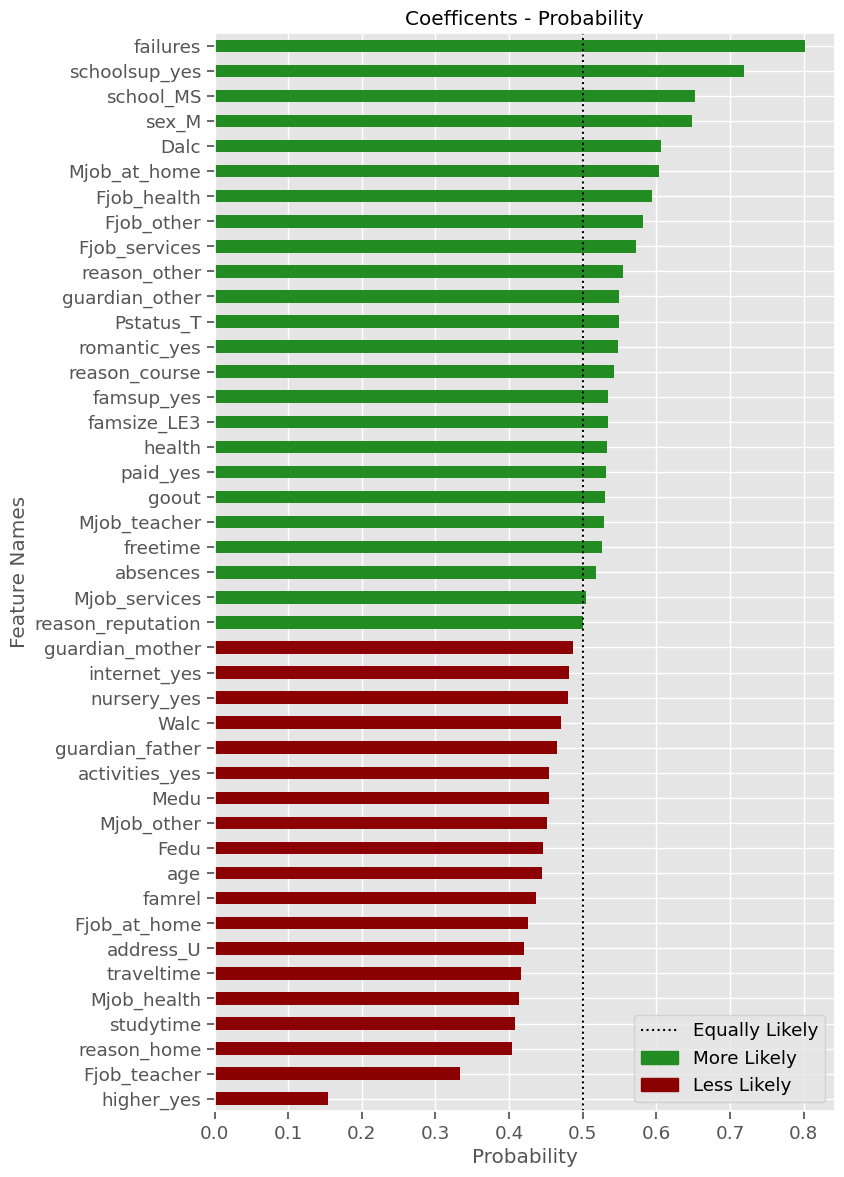

In [70]:
ax = plot_coeffs_color(coeffs_prob,threshold=.5, figsize=(8,14))
ax.set(title='Coefficents - Probability', xlabel='Probability')
fig = ax.get_figure()
fig.savefig('images/prob_coeffs.png', transparent=False)

## Log Reg Coefficients - cut content

### TBD: Keep? -

- From Mini-lesson on from Linear to Logistic Regression.
- Forget how it fits in narrative?
    - Shows that model predicts class.

In [71]:
i = 100
X_test_df.iloc[i].head()

age           17.0
Medu           4.0
Fedu           1.0
traveltime     2.0
studytime      1.0
Name: 325, dtype: float64

In [72]:
# ## Let's check what our model would predict
logreg.predict(X_test_df.iloc[i].values.reshape(1,-1))

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([ True])

#### What did we get?
> Hey...thats not odds or probability!

- Nope! scikit-learn's `logreg.predict` method assumes you wanted to know which **class/label** was more likely. 
- To find out the **probability** of being an Expensive Home, we can use `logreg.predict_proba`

In [73]:
## get the probabilities using predict_proba
logreg.predict_proba(X_test_df.iloc[i].values.reshape(1,-1))

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([[0.16615659, 0.83384341]])

In [74]:
## OK, so what is the ACTUAL class of our example home?
y_test.iloc[i]

True